In [2]:
#import Dependencies
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imghdr

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
gpus =  tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
print('happy: ',len(os.listdir('drive/MyDrive/Training/Datasets/HSC/happy')), ' samples')
print('sad: ', len(os.listdir('drive/MyDrive/Training/Datasets/HSC/sad')),' samples')

happy:  403  samples
sad:  469  samples


# Cleaning


In [6]:
data_dir = 'drive/MyDrive/Training/Datasets/HSC'
image_exts = ['jpeg', 'jpg', 'png', 'bmp']
image_calss = os.listdir(data_dir)

In [7]:
def Remove_outliers(data_dir = data_dir):
  for image_class in os.listdir(data_dir):
      class_dir = os.path.join(data_dir, image_class)
      if os.path.isdir(class_dir):
          for image in os.listdir(class_dir):
              image_path = os.path.join(class_dir, image)
              try:
                  img = cv2.imread(image_path)
                  img_extension = imghdr.what(image_path)
                  if img_extension not in image_exts:
                      print('Image not in ext list: {}'.format(image_path))
                      os.remove(image_path)
              except Exception as e:
                  print('Issue with image {}: {}'.format(image_path, str(e)))

In [8]:
Remove_outliers()

# Load Data

In [9]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(256, 256), batch_size=32)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 872 files belonging to 2 classes.


# Visualusation

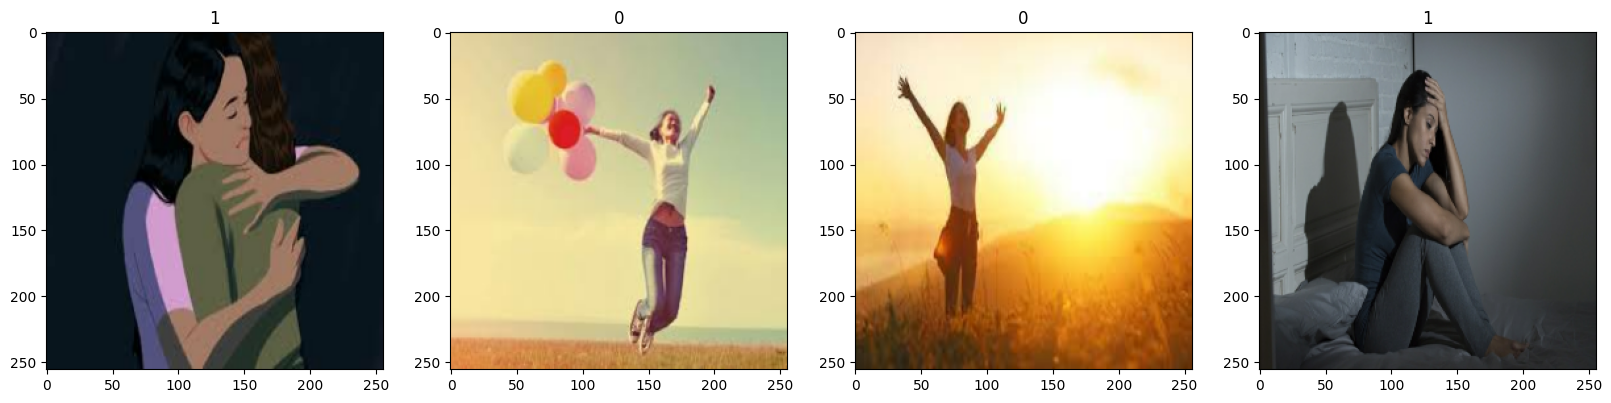

In [10]:
fig, ax = plt.subplots(ncols=4 , figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 0 ==> Happy
# 1 ==> Sad

# Preprocessing

In [11]:
#Scale Data
data = data.map(lambda x,y: (x/255, y))

# Splitting data

In [13]:
train_size = int(len(data) * 0.7)
val_size   = int(len(data) * 0.2) + 1
test_size  = int(len(data) * 0.1) + 1

In [14]:
train = data.take(train_size)
val   = data.skip(train_size).take(val_size)
test  = data.skip(train_size + val_size).take(test_size)

# The model


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [16]:
#Create the model
model = Sequential()

In [17]:
#(1, 256, 256, 3)
model.add(Conv2D(16, (3,3), 1 , activation='relu', input_shape = (256, 256, 3)))    #TensorShape([1, 254, 254, 16])
model.add(MaxPooling2D())                                                           #TensorShape([1, 127, 127, 16])

In [18]:
model.add(Conv2D(32, (3,3), 1 , activation= 'relu'))                                #TensorShape([1, 125, 125, 32])
model.add(MaxPooling2D())                                                           #TensorShape([1, 62, 62, 32])

In [19]:
model.add(Conv2D(16, (3,3), 1 , activation= 'relu'))                                #TensorShape([1, 60, 60, 16])
model.add(MaxPooling2D())                                                           #TensorShape([1, 30, 30, 16])

In [20]:
model.add(Flatten())                                                                #TensorShape([1, 14400])

In [21]:
model.add(Dense(256, activation='relu'))                                            #TensorShape([1, 256])
model.add(Dense(1, activation='sigmoid'))                                            #TensorShape([1, 1])

In [22]:
# compile the model
model.compile(
    optimizer='adam',
    loss= tf.losses.BinaryCrossentropy(),
    metrics = ['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [24]:
#Fit the model
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir ='logs')

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
19/19 [==============================] - 23s 437ms/step - loss: 0.8116 - accuracy: 0.5658 - val_loss: 0.5475 - val_accuracy: 0.7344
Epoch 2/20
19/19 [==============================] - 15s 745ms/step - loss: 0.5582 - accuracy: 0.7270 - val_loss: 0.4516 - val_accuracy: 0.8177
Epoch 3/20
19/19 [==============================] - 11s 485ms/step - loss: 0.3924 - accuracy: 0.8289 - val_loss: 0.3599 - val_accuracy: 0.8490
Epoch 4/20
19/19 [==============================] - 11s 533ms/step - loss: 0.2425 - accuracy: 0.9145 - val_loss: 0.2305 - val_accuracy: 0.9323
Epoch 5/20
19/19 [==============================] - 9s 397ms/step - loss: 0.2028 - accuracy: 0.9359 - val_loss: 0.1851 - val_accuracy: 0.9375
Epoch 6/20
19/19 [==============================] - 10s 445ms/step - loss: 0.1542 - accuracy: 0.9589 - val_loss: 0.1664 - val_accuracy: 0.9427
Epoch 7/20
19/19 [==============================] - 10s 482ms/step - loss: 0.1450 - accuracy: 0.9638 - val_loss: 0.1943 - val_accuracy: 0.9062


In [39]:
print(f'Validation accuracy: {tf.round(model.evaluate(val, verbose=0)[1]*100,2)}%')
print(f'Test accuracy: {tf.round(model.evaluate(test, verbose=0)[1]*100,2)}%')

Validation accuracy: 98.0%
Test accuracy: 99.0%


# Save Model


In [27]:
from tensorflow.keras.models import load_model

In [28]:

model.save(os.path.join('drive/MyDrive/Training/Save_models', 'HSC_mosel.h5'))

In [ ]:
#import the model
#new_model = load_model(os.path.join('drive/MyDrive/models', 'HSIClassification.h5'))